In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,CSVLogger,TensorBoard
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
import seaborn as sns

In [37]:
dataset = pd.read_csv("Datasets/Android_Ransomeware.csv")
dataset = dataset. iloc[:, 1:]
dataset = dataset[[" Source IP", "Label"]]
print("Original dataset size: ",dataset.shape)

pletors = dataset[dataset['Label'] == 'Pletor']  # Select rows with Label = 'Pletor'
non_pletors = dataset[(dataset['Label'] != 'Pletor') & (dataset['Label'] != 'Benign')]  # Select rows not 'Pletor' or 'Benign'

# Randomly sample rows from non_pletors equal to the number of pletors
non_pletors_sample = non_pletors.sample(n=len(pletors), random_state=42)

# Combine the two subsets
dataset = pd.concat([pletors, non_pletors_sample], ignore_index=True)

dataset['Label'] = dataset['Label'].apply(lambda x: 1 if x == 'Pletor' else 0)

# Step 6: Reset the index for the combined DataFrame
dataset = dataset.reset_index(drop=True)

print(f"Number of unique values in the 'Label' column: {dataset['Label'].nunique()}")
print(dataset.head())

Original dataset size:  (392034, 2)
Number of unique values in the 'Label' column: 2
        Source IP  Label
0  172.217.12.206      1
1  172.217.12.206      1
2  172.217.12.206      1
3    157.56.52.23      1
4    157.56.52.23      1


In [18]:
def handle_dups_n_nans(dataSet):
    dataSet = dataSet.drop_duplicates()
    dataSet.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataSet.dropna(inplace=True)

    return dataSet

def normalise_features(dataSet):
    numerical_features = dataSet.select_dtypes(include=['float64', 'int64']).columns

    mean = dataSet[numerical_features].mean()
    std = dataSet[numerical_features].std()

    dataSet[numerical_features] = (dataSet[numerical_features] - mean) / std

    return dataSet

def encode_categorical(dataSet):
    categorical_columns = dataSet.select_dtypes(exclude=['float64', 'int64']).columns

    for column in categorical_columns:
        unique_categories = dataSet[column].unique()
        category_to_label = {category: label for label, category in enumerate(unique_categories)}
        dataSet[column] = dataSet[column].map(category_to_label)

    return dataSet

def perform_preprocessing(dataSet):
    temp = normalise_features(dataSet)
    temp = encode_categorical(temp)
    return temp

def split_Xy(df):
    X = df.drop('Label', axis=1)
    y = df['Label']
    return X, y

# dataset = perform_preprocessing(dataset)
# dataset.head()

In [38]:
train_ratio = 0.8
n_samples = dataset.shape[0]
indices = np.random.permutation(n_samples)

train_size = int(train_ratio * n_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = dataset.iloc[train_indices]
test_data = dataset.iloc[test_indices]

train_data = handle_dups_n_nans(train_data)
test_data = handle_dups_n_nans(test_data)

X_train, y_train = split_Xy(train_data)
X_test, y_test = split_Xy(test_data)

X_train = perform_preprocessing(X_train)
X_test = perform_preprocessing(X_test)

print("Train shape: ",X_train.shape," ",y_train.shape)
print("Test shape: ",X_test.shape," ",y_test.shape)

print(X_train.head())
print(y_train.head())


Train shape:  (487, 1)   (487,)
Test shape:  (222, 1)   (222,)
       Source IP
2855           0
3098           1
6968           2
3616           2
7430           3
2855    1
3098    1
6968    0
3616    1
7430    0
Name: Label, dtype: int64


C:\Users\archi\AppData\Local\Temp\ipykernel_21064\1967025077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\archi\AppData\Local\Temp\ipykernel_21064\1967025077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.dropna(inplace=True)


In [39]:
# print(f"Number of unique values in the 'Timestamp' column: {X_train[' Timestamp'].nunique()}")
print(f"Number of unique values in the 'Source IP' column: {X_train[' Source IP'].nunique()}")

Number of unique values in the 'Source IP' column: 436


In [52]:
# lets make our NN model layers
np.random.seed(42)
tf.random.set_seed(42)
num_features = 1
num_classes = 1
noOfEpochs=100
learningRate = 0.0005

model = Sequential([
    Dense(32, activation='leaky_relu', input_shape=(num_features,),kernel_initializer=HeNormal()),  # Input Layer
    Dense(16, activation='leaky_relu', kernel_regularizer=l2(0.01), kernel_initializer=HeNormal()),
    Dense(num_classes, activation='sigmoid')  # Output Layer
])

optimizer = Adam(learning_rate=learningRate)

model.compile(
    optimizer=optimizer,  # Adaptive Moment Estimation optimizer
    loss='binary_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Tracking accuracy during training
)

model.summary()

C:\Users\archi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 32)                  │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Training the model
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
checkpoint = ModelCheckpoint(
    filepath='model_checkpoint.keras',
    monitor='loss',
    save_best_only=True,
    verbose=1
)
tensorboard = TensorBoard(log_dir="logs", histogram_freq=1)
csv_logger = CSVLogger('training_log.csv', append=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=noOfEpochs,  # Number of training epochs
    batch_size=32,  # Mini-batch size
    verbose=1,  # Display training progress
    callbacks=[reduce_lr,checkpoint, csv_logger, tensorboard]
)

Epoch 1/100
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5286 - loss: 2.5889
Epoch 1: loss improved from inf to 1.60970, saving model to model_checkpoint.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5261 - loss: 2.3094 - val_accuracy: 0.4054 - val_loss: 1.0096 - learning_rate: 5.0000e-04
Epoch 2/100
 9/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5841 - loss: 1.0024 
Epoch 2: loss improved from 1.60970 to 0.99387, saving model to model_checkpoint.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5714 - loss: 0.9979 - val_accuracy: 0.6441 - val_loss: 0.9981 - learning_rate: 5.0000e-04
Epoch 3/100
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4952 - loss: 1.0227 
Epoch 3: loss did not improve from 0.99387
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5144 - loss: 1.0183 - val_accuracy: 0.4144 - val_loss: 1.0133 - learning_rate: 5.0000e-04
Epoch 4/100
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6250 - loss: 0.9788
Epoch 4: los

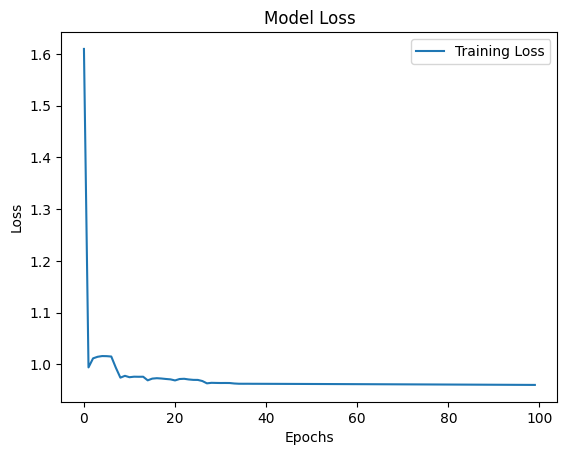

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

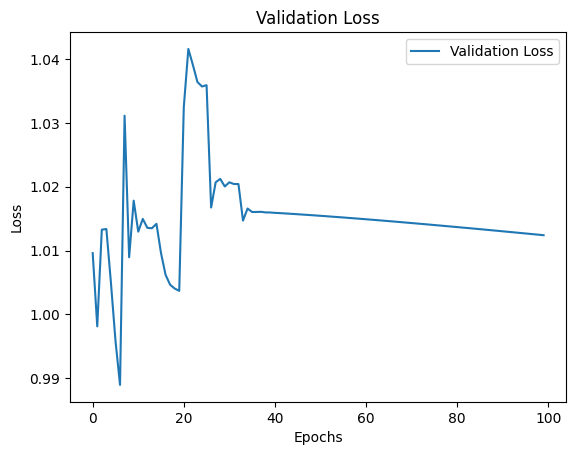

In [55]:
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

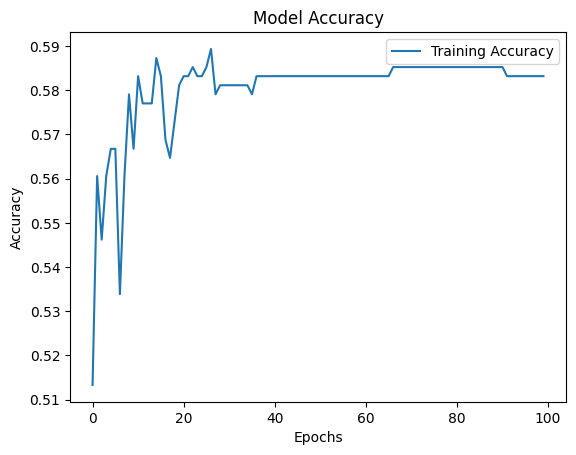

In [56]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

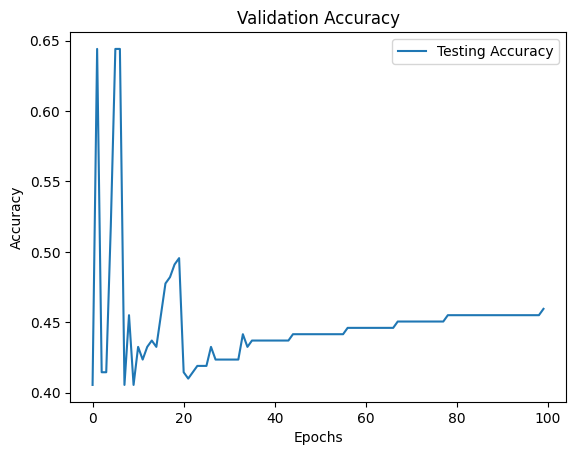

In [57]:
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()